# Unsupervised learning on categorical data
## DS-Xciting | 25 March 2021
### Azamat Omuraliev

In [1]:
!pip3 install -q kmodes
!pip3 install -q Categorical-similarity-measures
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

import Categorical_similarity_measures.IOF as IOF
from sklearn.neighbors import DistanceMetric


## Helper functions

### KMeans
### PCA + KMeans
### GMM (Gaussian Mixture Models)
### KModes
### KPrototypes

In [2]:
def run_kmeans(n_clusters, features, features_to_visualize, axs, title=''):
    kmeans = KMeans(n_clusters)
    kmeans.fit(features)
    axs = visualize_clusters(axs, kmeans.labels_, features_to_visualize, title)
    return kmeans.labels_, axs

def run_pca_kmeans(n_clusters, features, features_to_visualize, axs, title=''):
    pca = PCA(n_clusters)
    features = pca.fit_transform(features)
    
    kmeans = KMeans(n_clusters)
    kmeans.fit(features)
    axs = visualize_clusters(axs, kmeans.labels_, features_to_visualize, title)
    return kmeans.labels_, axs

def run_pca_gaussian_mixture(n_clusters, features, features_to_visualize, axs, title=''):
    pca = PCA(n_clusters)
    features = pca.fit_transform(features)
    
    gmm = GaussianMixture(n_clusters)
    labels = gmm.fit_predict(features)
    axs = visualize_clusters(axs, labels, features_to_visualize, title)
    return labels, axs

def run_gaussian_mixture(n_clusters, features, features_to_visualize, axs, title=''):
    gmm = GaussianMixture(n_clusters)
    labels = gmm.fit_predict(features)
    axs = visualize_clusters(axs, labels, features_to_visualize, title)
    return labels, axs

def run_kmodes(n_clusters, features, features_to_visualize, axs, title=''):
    kmodes = KModes(n_clusters)
    labels = kmodes.fit_predict(features)
    axs = visualize_clusters(axs, labels, features_to_visualize, title)
    return labels, axs

def run_kprototypes(n_clusters, features, features_to_visualize, axs, title=''):
    kprototypes = KPrototypes(n_clusters)
    categorical_indices = list(range(features_to_visualize.shape[1], features.shape[1]))
    kprototypes = kprototypes.fit(features, categorical=categorical_indices)
    labels = kprototypes.predict(features, categorical=categorical_indices)
    axs = visualize_clusters(axs, labels, features_to_visualize, title)
    return labels, axs

### Pipeline to compare and visualize algorithms

In [3]:
def visualize_clusters(axs, labels, features_to_visualize, title):
    for g in np.unique(labels):
        ix = np.where(labels == g)
        axs.scatter(features_to_visualize[ix, 0], features_to_visualize[ix, 1], 
                    label=g,
                    marker='o')
    axs.title.set_text(title)
    return axs

def run_comparison(num_features, cat_features, 
                   algorithms=[run_kmeans],
                   algorithm_names=['KMeans'],
                   title=''):
    
    fig, axs = plt.subplots(1, len(algorithms), figsize=(16,7))
    labels_per_algorithm = {algorithm_name: [] for algorithm_name in algorithm_names}
    
    features = np.concatenate((num_features, cat_features), axis=1) if cat_features.size > 0 else num_features
    for i, algo in enumerate(algorithms):

        labels, axs[i] = algo(n_clusters, 
                           features, 
                           num_features, axs[i], title=f'{algorithm_names[i]}')
        labels_per_algorithm[algorithm_names[i]] = labels
        
    fig.suptitle(f'Clustering algorithms on {title} features', fontsize=15)
    fig.show()
    
    return labels_per_algorithm
    
#     labels_uniform, axs[0,0] = algorithm(n_categorical_classes, 
#                categorical_uniform, 
#                features, axs[0,0], title=f'clusters on labels: uniform | {title}')
#     axs[0,2] = visualize_clusters(axs[0,2], ordinal_uniform, features, title=f'labels: uniform | {title}')


## Let's define some global parameters

In [4]:
n_categorical_features = 1 # number of categorical features
n_categorical_classes = 5 # number of possible unique values per categorical feature
n_clusters = 5 # number of clusters, used for clustering algorithms and for generating numerical data

n_samples = 500 

## Clustering on numerical and categorical data

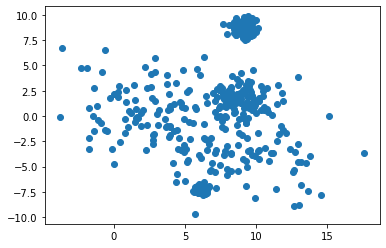

In [5]:
features, _ = make_blobs(n_samples=n_samples, n_features=2, centers=n_clusters,
                               cluster_std=[1.0, 2.5, 0.5, 3.0, 0.25])
plt.scatter(features[:, 0], features[:, 1])
plt.show()

<ipython-input-3-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


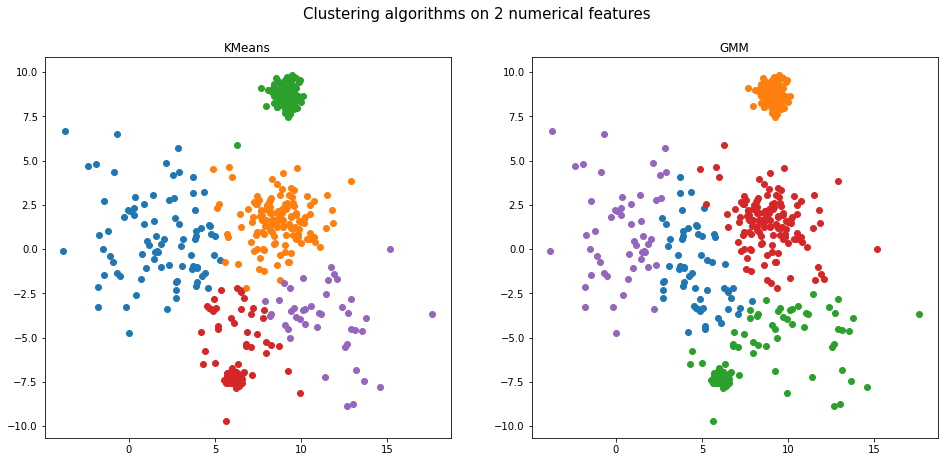

In [6]:
_ = run_comparison(features, np.asarray([]),
               algorithms=[run_kmeans, run_gaussian_mixture],
               algorithm_names=['KMeans', 'GMM'],
               title='2 numerical')

### Let's add categorical features to the picture, sampled from multinomial distribution

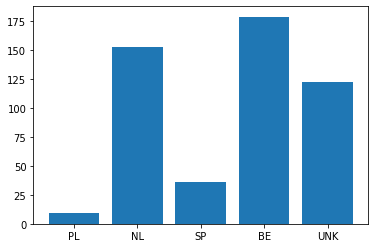

In [14]:
def create_multinomial_discrete_features():
    categorical_multinomial = np.random.multinomial(n=1, 
                                                pvals=np.squeeze(np.random.dirichlet(0.7 * np.ones(n_categorical_classes), size=1)), 
                                                size=n_samples)
    ordinal_multinomial = np.expand_dims(np.argmax(categorical_multinomial, axis=1), axis=1)
    return ordinal_multinomial, categorical_multinomial
    

def analyze_categorical_features(data, labels=None):
    counts = np.unique(data, return_counts=True)[1]
    labels = list(range(len(counts))) if labels is None else labels
    plt.bar(labels, counts)
    plt.show()
    
ordinal_multinomial, categorical_multinomial = create_multinomial_discrete_features()
analyze_categorical_features(ordinal_multinomial, ['PL', 'NL', 'SP', 'BE', 'UNK'])

<ipython-input-3-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


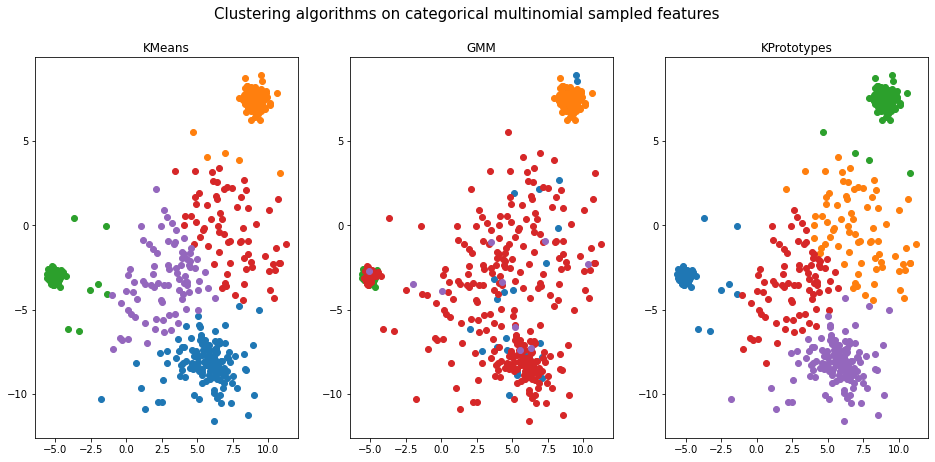

In [9]:
_ = run_comparison(features, categorical_multinomial,
               algorithms=[run_kmeans, run_gaussian_mixture, run_kprototypes],
               algorithm_names=['KMeans', 'GMM', 'KPrototypes'],
               title='categorical multinomial sampled')

### What if we sample categorical features uniformly?

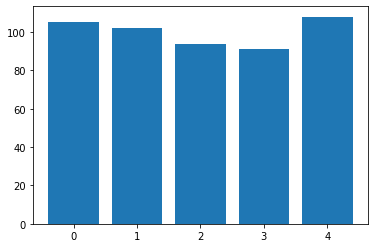

In [13]:
def create_uniform_discrete_features():
    ordinal_uniform = np.random.randint(0, n_categorical_classes, (n_samples, n_categorical_features))
    categorical_uniform = np.zeros((ordinal_uniform.size, ordinal_uniform.max()+1))
    categorical_uniform[np.arange(ordinal_uniform.size), np.squeeze(ordinal_uniform)] = 1
    return ordinal_uniform, categorical_uniform

ordinal_uniform, categorical_uniform = create_uniform_discrete_features()
analyze_categorical_features(ordinal_uniform)

<ipython-input-8-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


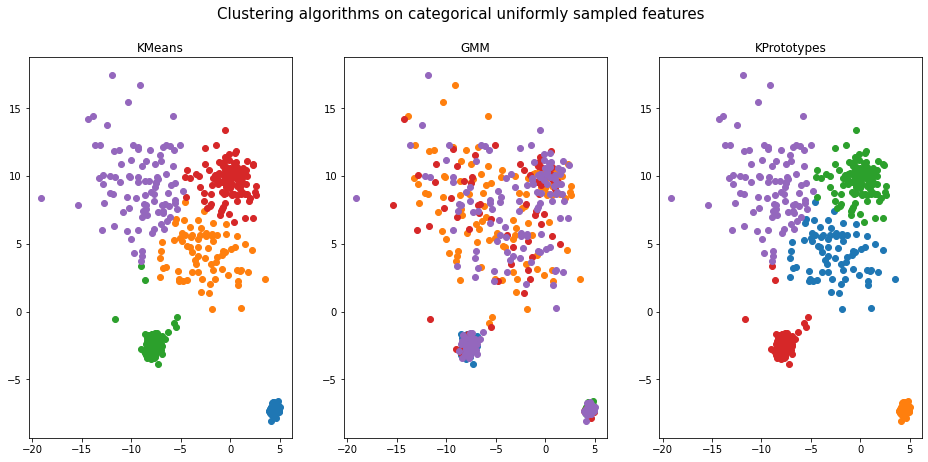

In [14]:
_ = run_comparison(features, categorical_uniform,
               algorithms=[run_kmeans, run_gaussian_mixture, run_kprototypes],
               algorithm_names=['KMeans', 'GMM', 'KPrototypes'],
               title='categorical uniformly sampled')

### And what if we cluster over normally distributed data? 

<ipython-input-8-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


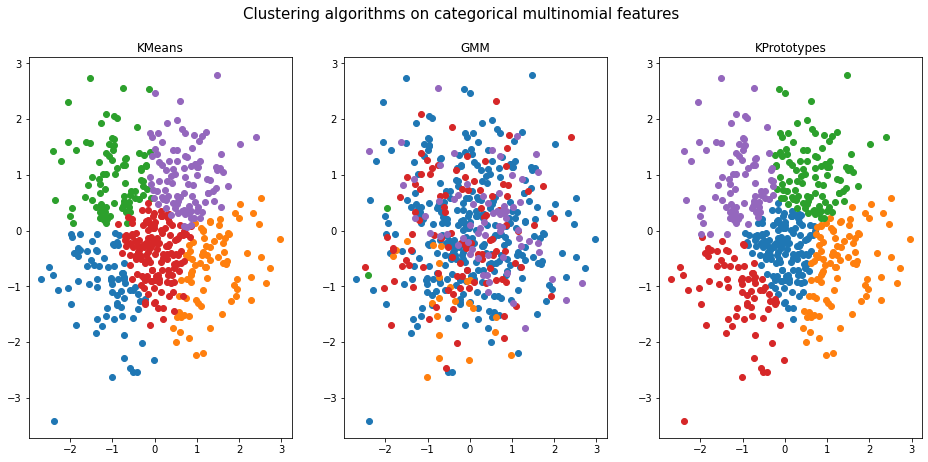

In [15]:
normal_features = np.random.normal(size=(n_samples, 2))
_ = run_comparison(normal_features, categorical_uniform,
               algorithms=[run_kmeans, run_gaussian_mixture, run_kprototypes],
               algorithm_names=['KMeans', 'GMM', 'KPrototypes'],
               title='categorical multinomial')

<ipython-input-8-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


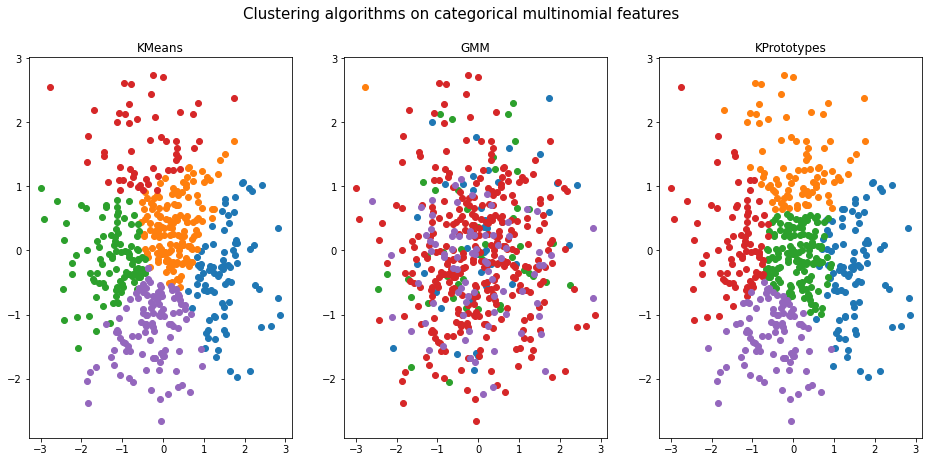

In [16]:
normal_features = np.random.normal(size=(n_samples, 2))
_ = run_comparison(normal_features, categorical_multinomial,
               algorithms=[run_kmeans, run_gaussian_mixture, run_kprototypes],
               algorithm_names=['KMeans', 'GMM', 'KPrototypes'],
               title='categorical multinomial')

## Calculating distance metrics

In [17]:
categorical_multinomial

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

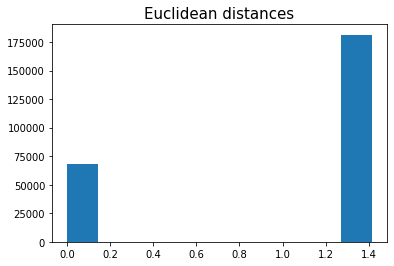

Unique values: [0.         1.41421356]


In [18]:
dist = DistanceMetric.get_metric('euclidean')
d = dist.pairwise(categorical_multinomial)
plt.hist(d.flatten())
plt.title(f'Euclidean distances', fontsize=15)
plt.show()
print(f'Unique values: {np.unique(d)}')

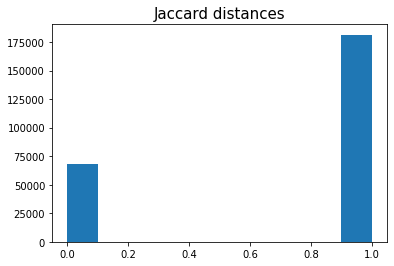

Unique values: [0. 1.]


In [19]:
dist = DistanceMetric.get_metric('jaccard')
d = dist.pairwise(categorical_multinomial)
plt.hist(d.flatten())
plt.title(f'Jaccard distances', fontsize=15)
plt.show()
print(f'Unique values: {np.unique(d)}')

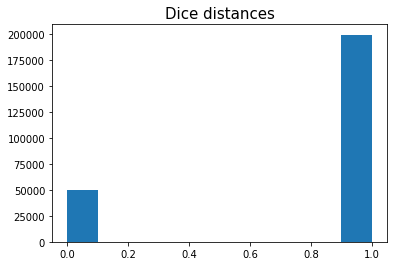

Unique values: [0. 1.]


In [20]:
dist = DistanceMetric.get_metric('dice')
plt.hist(dist.pairwise(categorical_uniform).flatten())
plt.title(f'Dice distances', fontsize=15)
plt.show()
print(f'Unique values: {np.unique(d)}')

In [21]:
class CategoricalSimilarity():

    def __init__(self, data):
        self.data = data
        self.n = data.shape[0]
        self.d = data.shape[1]

    def overlap(self):
        score = np.zeros((self.n, self.n))
        for i, X in enumerate(self.data):
            score[i] = 1. * np.sum(self.data==X, axis=1) / self.d
        return score

    def eskin(self):
        score = np.zeros((self.n, self.n))
        n_k = [len(np.unique(data[:, x])) for x in iter(range(data.shape[1]))]
        for i, X in enumerate(self.data):
            tmp_bool = data==X
            tmp_x = np.zeros(self.data.shape)
            for k in iter(range(self.d)):
                tmp_x[:, k][tmp_bool[:, k] == True] = 1.0 / self.d
                tmp_x[:, k][tmp_bool[:,k] == False] = 1.0 * n_k[k]**2 / (n_k[k]**2 + 2) / self.d
            score[i] = np.sum(tmp_x, axis=1)
        return score

    def iof(self):
        score = np.zeros((self.n, self.n))
        f_k_d = [dict(zip(np.unique(self.data[:, x], return_counts=True)[0], np.unique(self.data[:, x], return_counts=True)[1])) for x in iter(range(self.d))]
        for i, X in enumerate(self.data):
            tmp_x = np.zeros(self.data.shape)
            for k in iter(range(self.d)):
                f_k_x = f_k_d[k].get(X[k], 0)
                for val, f_k_y in f_k_d[k].items():
                    if val == X[k]:
                        tmp_x[:, k][self.data[:, k] == val] = 1. / self.d
                    else:
                        tmp_x[:, k][self.data[:, k] == val] = 1. / (1 + np.log(f_k_x) * np.log(f_k_y)) / self.d
            score[i] = np.sum(tmp_x, axis=1)
        return score

    def of(self):
        score = np.zeros((self.n, self.n))
        f_k_d = [dict(zip(np.unique(self.data[:, x], return_counts=True)[0], np.unique(self.data[:, x], return_counts=True)[1])) for x in iter(range(self.d))]
        for i, X in enumerate(self.data):
            tmp_x = np.zeros(self.data.shape)
            for k in iter(range(self.d)):
                f_k_x = f_k_d[k].get(X[k], 0)
                for val, f_k_y in f_k_d[k].items():
                    if val == X[k]:
                        tmp_x[:, k][self.data[:, k] == val] = 1. / self.d
                    else:
                        tmp_x[:, k][self.data[:, k] == val] = 1. / (1 + np.log(1.*self.n/f_k_x) * np.log(1.*self.n/f_k_y)) / self.d
            score[i] = np.sum(tmp_x, axis=1)
        return score

    def goodall3(self):
        score = np.zeros((self.n, self.n))
        p_2_k_d = [dict(zip(np.unique(self.data[:, x], return_counts=True)[0], 1.*np.unique(self.data[:, x], return_counts=True)[1]*(np.unique(self.data[:, x], return_counts=True)[1]-1)/self.n/(self.n-1)))  for x in iter(range(self.d))]
        for i, X in enumerate(self.data):
            tmp_bool = self.data==X
            tmp_x = np.zeros(self.data.shape)
            for k in iter(range(self.d)):
                tmp_x[:, k][tmp_bool[:, k] == True] = 1. * (1 - p_2_k_d[k].get(X[k], 0)) / self.d
            score[i] = np.sum(tmp_x, axis=1)
        return score

    def goodall4(self):
        score = np.zeros((self.n, self.n))
        p_2_k_d = [dict(zip(np.unique(self.data[:, x], return_counts=True)[0], 1.*np.unique(self.data[:, x], return_counts=True)[1]*(np.unique(data[:, x], return_counts=True)[1]-1)/self.n/(self.n-1)))  for x in iter(range(self.d))]
        for i, X in enumerate(self.data):
            tmp_bool = data==X
            tmp_x = np.zeros(self.data.shape)
            for k in iter(range(self.d)):
                tmp_x[:, k][tmp_bool[:, k] == True] = 1. * p_2_k_d[k].get(X[k], 0) / self.d
            score[i] = np.sum(tmp_x, axis=1)
        return score

In [22]:
sim = CategoricalSimilarity(categorical_multinomial)


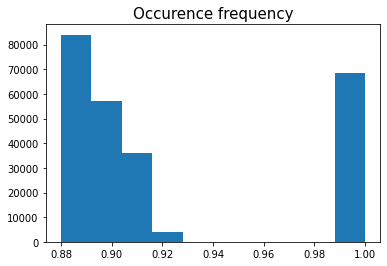

Unique values: [0.87987687 0.8866887  0.89485388 0.89720159 0.90060275 0.90536676
 0.90876793 0.91217859 0.91557976 0.92609264 1.        ]


In [23]:
d = sim.of().flatten()
plt.hist(d)
plt.title(f'Occurence frequency', fontsize=15)
plt.show()
print(f'Unique values: {np.unique(d)}')

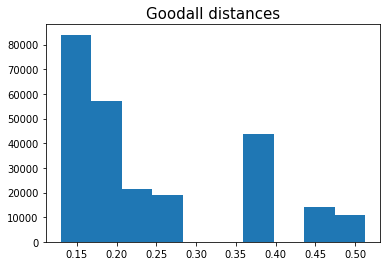

Unique values: [0.12974429 0.15213307 0.17576273 0.18159198 0.20115271 0.22478236
 0.23061162 0.24717114 0.2530004  0.27663006 0.37823006 0.45103006
 0.47903006 0.50623006 0.51263006]


In [24]:
d = sim.goodall3().flatten()
plt.hist(d)
plt.title(f'Goodall distances', fontsize=15)
plt.show()
print(f'Unique values: {np.unique(d)}')

In [25]:
d = sim.iof().flatten()
print(f'Unique values: {np.unique(d)}')

Unique values: [0.61319911 0.61361884 0.61404198 0.61445747 0.61480525 0.61488061
 0.6152284  0.61530034 0.61564813 0.61648676 1.        ]


In [26]:
d = sim.overlap().flatten()
print(f'Unique values: {np.unique(d)}')

Unique values: [0.6 1. ]


## Applying PCA before clustering

<ipython-input-8-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


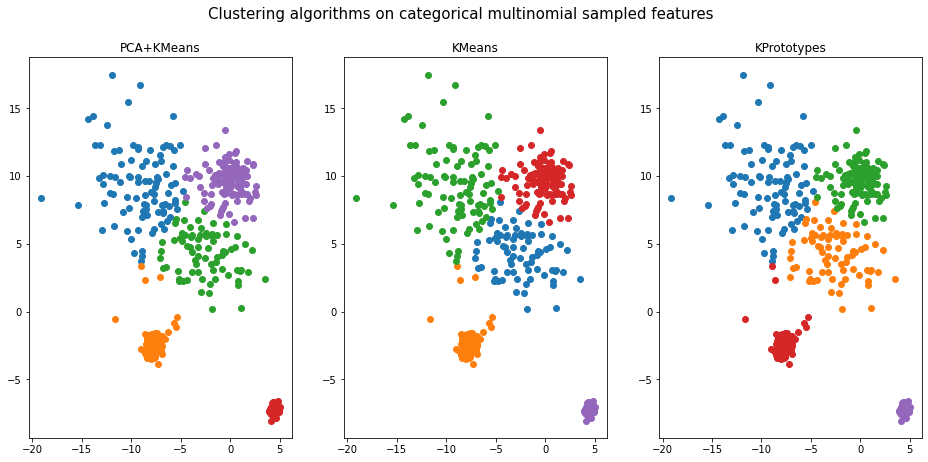

In [27]:
_ = run_comparison(features, categorical_multinomial,
               algorithms=[run_pca_kmeans, run_kmeans, run_kprototypes],
               algorithm_names=['PCA+KMeans', 'KMeans', 'KPrototypes'],
               title='categorical multinomial sampled')

<ipython-input-8-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


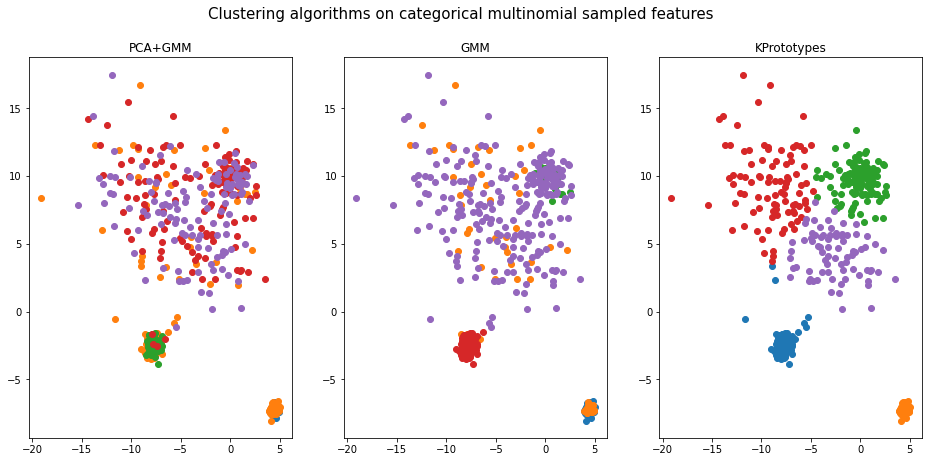

In [28]:
_ = run_comparison(features, categorical_multinomial,
               algorithms=[run_pca_gaussian_mixture, run_gaussian_mixture, run_kprototypes],
               algorithm_names=['PCA+GMM', 'GMM', 'KPrototypes'],
               title='categorical multinomial sampled')

In [35]:
def analyze_labels_per_categorical_value(labels_per_algorithm, ordinal_multinomial):
    freqs = []
    for i in np.unique(ordinal_multinomial):
        value_index = np.argwhere(ordinal_multinomial == i)[:,0]
        ratio = np.unique(labels_per_algorithm[value_index], return_counts=True)[1].max() / value_index.size
#         print(f'{int(100 * ratio)}% of unique categorical value {i} were clustered together')
        freqs.append(round(100 * ratio, 4))
    return freqs
#         print(labels_per_algorithm[value_index])

<ipython-input-8-c47ef54169fb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


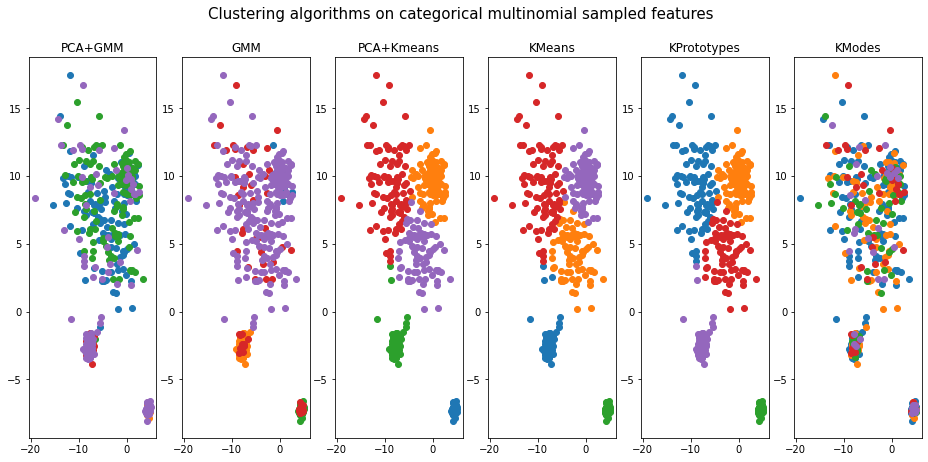

In [30]:
all_algorithms = ['PCA+GMM', 'GMM', 'PCA+Kmeans', 'KMeans', 'KPrototypes', 'KModes']
algorithm_frequencies = {}

### helper: get results for all algorithms
labels_per_algorithm = run_comparison(features, categorical_multinomial,
               algorithms=[run_pca_gaussian_mixture, run_gaussian_mixture, run_pca_kmeans, run_kmeans, run_kprototypes, run_kmodes],
               algorithm_names=['PCA+GMM', 'GMM', 'PCA+Kmeans', 'KMeans', 'KPrototypes', 'KModes'],
               title='categorical multinomial sampled')

In [36]:
for algo in all_algorithms:
    algorithm_frequencies[algo] = analyze_labels_per_categorical_value(labels_per_algorithm[algo], ordinal_multinomial)

In [37]:
import pandas as pd
df = pd.DataFrame(algorithm_frequencies)
df.loc['mean'] = df.mean()
df

,PCA+GMM,GMM,PCA+Kmeans,KMeans,KPrototypes,KModes
0,63.5593,63.55930,22.88140,22.88140,22.88140,100.0
1,51.1962,57.89470,26.79430,26.79430,26.79430,100.0
2,100.0000,79.59180,28.57140,28.57140,28.57140,100.0
3,57.8313,57.83130,21.68670,21.68670,21.68670,100.0
4,65.8537,80.48780,34.14630,34.14630,34.14630,100.0
mean,67.6881,67.87298,26.81602,26.81602,26.81602,100.0


In [33]:
analyze_labels_per_categorical_value(labels_per_algorithm['GMM'], ordinal_multinomial)

[63.56, 57.89, 79.59, 57.83, 80.49]

In [34]:
analyze_labels_per_categorical_value(labels_per_algorithm['KPrototypes'], ordinal_multinomial)

[22.88, 26.79, 28.57, 21.69, 34.15]

## P.S. KModes vs KPrototypes

<ipython-input-3-212bcb3ae882>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


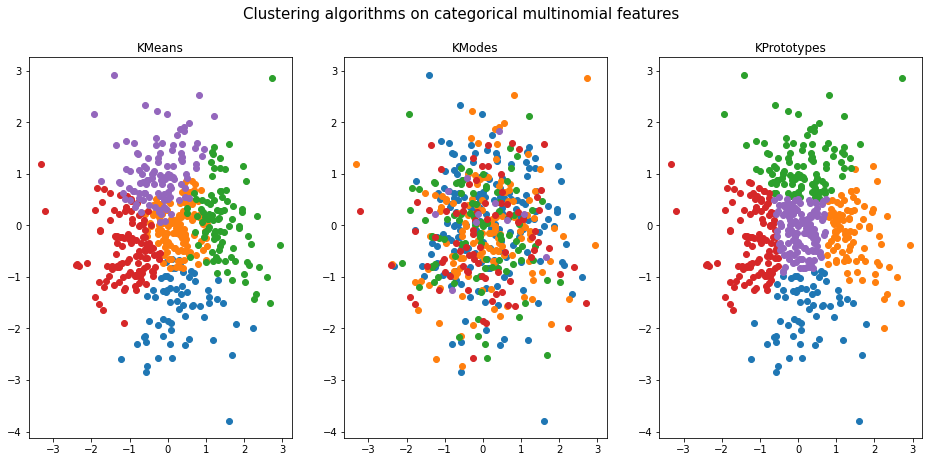

In [24]:
run_comparison(normal_features, categorical_multinomial,
               algorithms=[run_kmeans, run_kmodes, run_kprototypes],
               algorithm_names=['KMeans', 'KModes', 'KPrototypes'],
               title='categorical multinomial')

## Next steps
1. Check how stable the cluster predictions are
2. 

Counts of uniform class occurances
[118  97  93  96  96]
Counts of multinomial class occurances
[ 38  27 204  75 156]


In [40]:
# random_state = 42
# features, _ = make_blobs(n_samples=n_samples, n_features=2, random_state=random_state, centers=3,
#                                cluster_std=[1.0, 2.5, 0.5]
#                                )
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_kmeans)

In [27]:
# np.concatenate((features, categorical_multinomial), axis=1).shape
# fig, axs = plt.subplots(1, 4, figsize=(18,9))
# axs[1, 3]

<ipython-input-37-48cb71ff27b2>:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


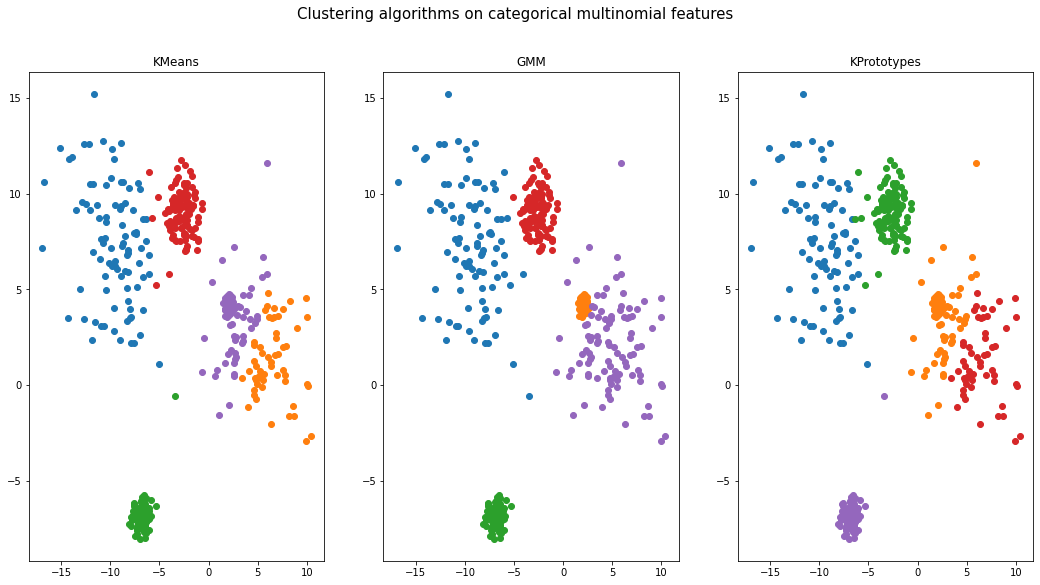

In [38]:
random_state = 42
features, _ = make_blobs(n_samples=n_samples, n_features=2, random_state=random_state, centers=n_clusters,
                               cluster_std=[1.0, 2.5, 0.5, 3.0, 0.25]
                        )
run_comparison(features, categorical_multinomial,
               algorithms=[run_kmeans, run_gaussian_mixture, run_kprototypes],
               algorithm_names=['KMeans', 'GMM', 'KPrototypes'],
               title='categorical multinomial')
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_kmeans)
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_pca_kmeans)
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_gaussian_mixture)
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_kmodes)
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_kprototypes)

In [42]:
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kmeans)
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_gaussian_mixture)
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kmodes)
# run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kprototypes)

<ipython-input-8-f18e53e77c49>:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-8-f18e53e77c49>:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-8-f18e53e77c49>:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-8-f18e53e77c49>:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


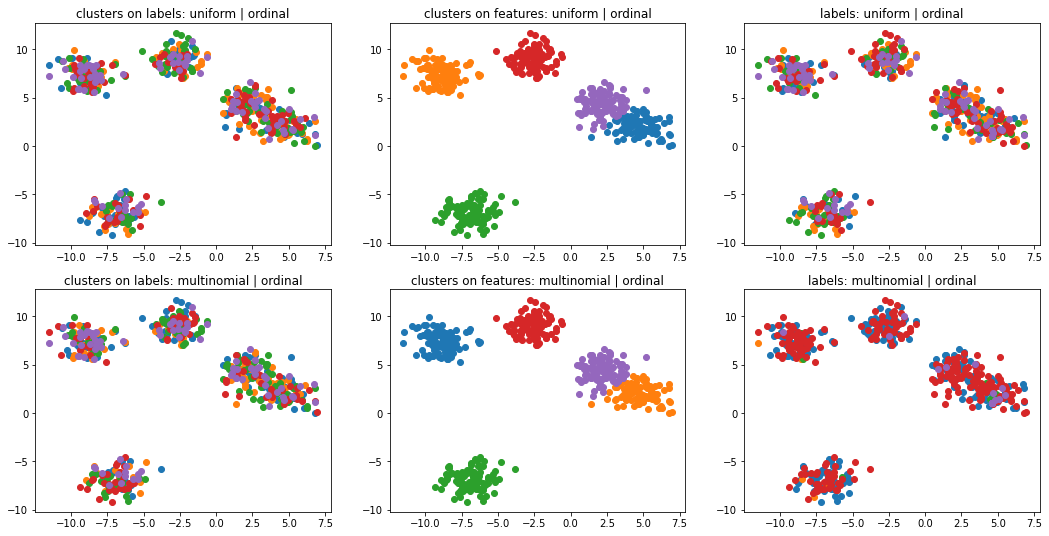

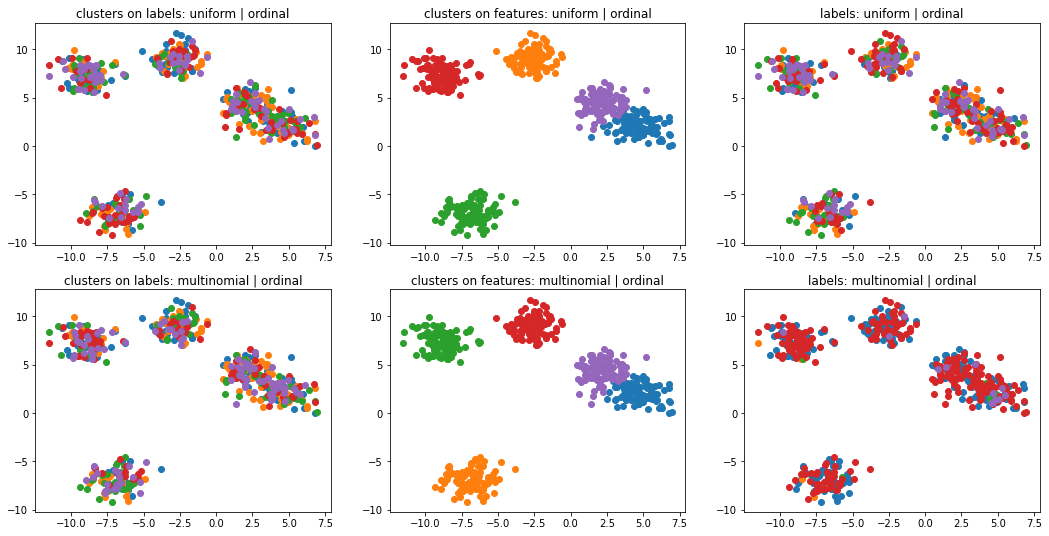

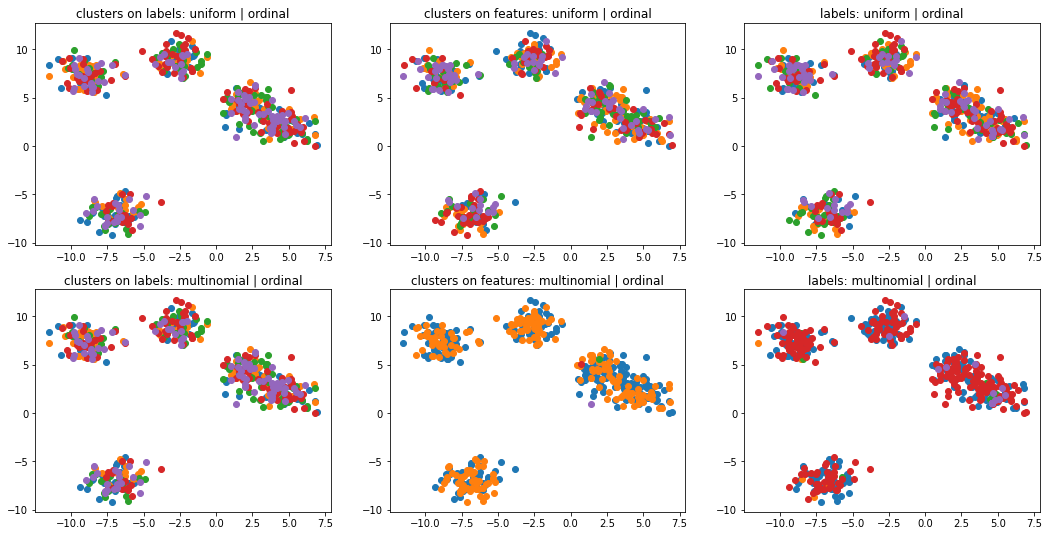

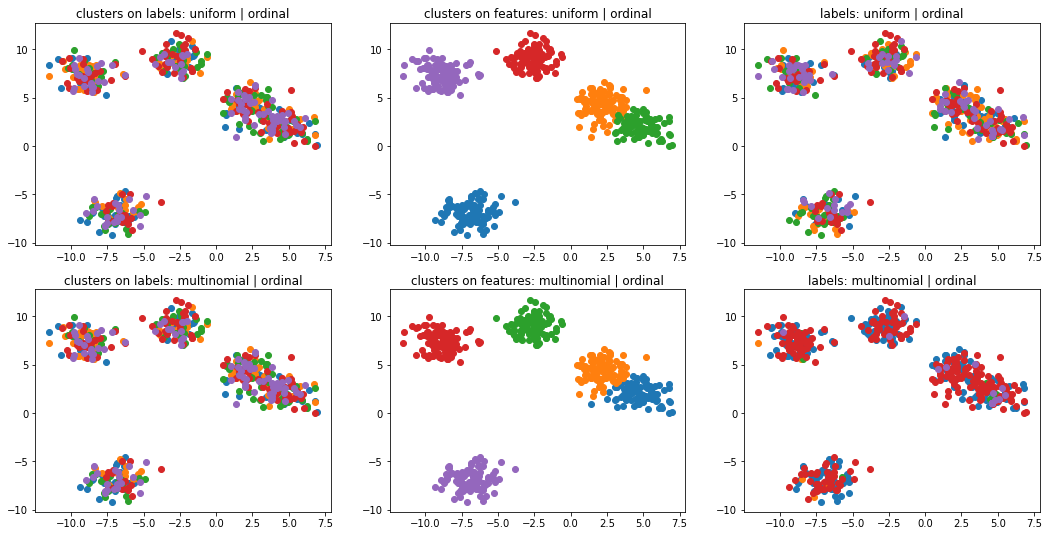

In [10]:
random_state = 42
features, _ = make_blobs(n_samples=n_samples, n_features=2, random_state=random_state, centers=n_clusters)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kmeans)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_gaussian_mixture)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kmodes)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kprototypes)


<ipython-input-5-d452ad958182>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-d452ad958182>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-d452ad958182>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


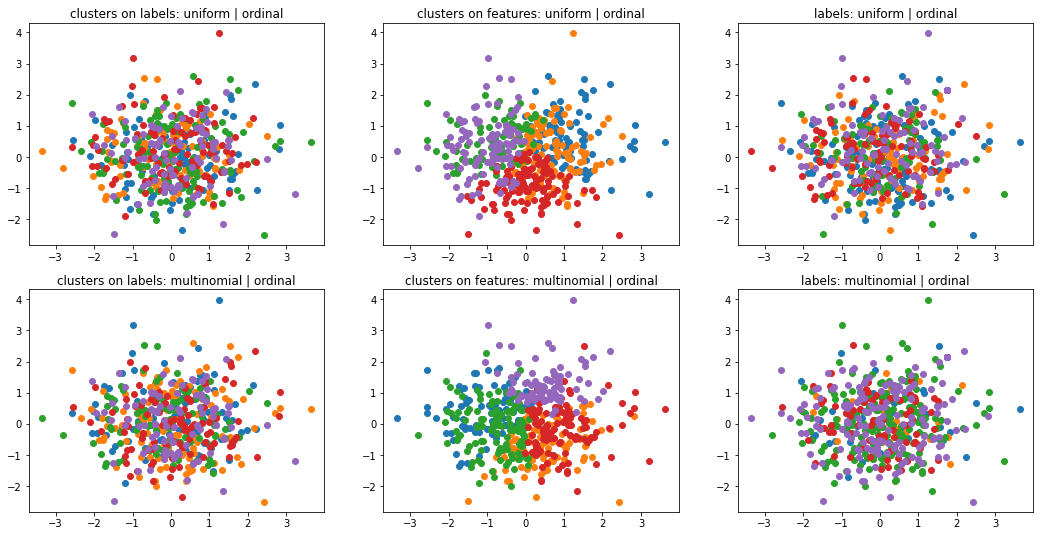

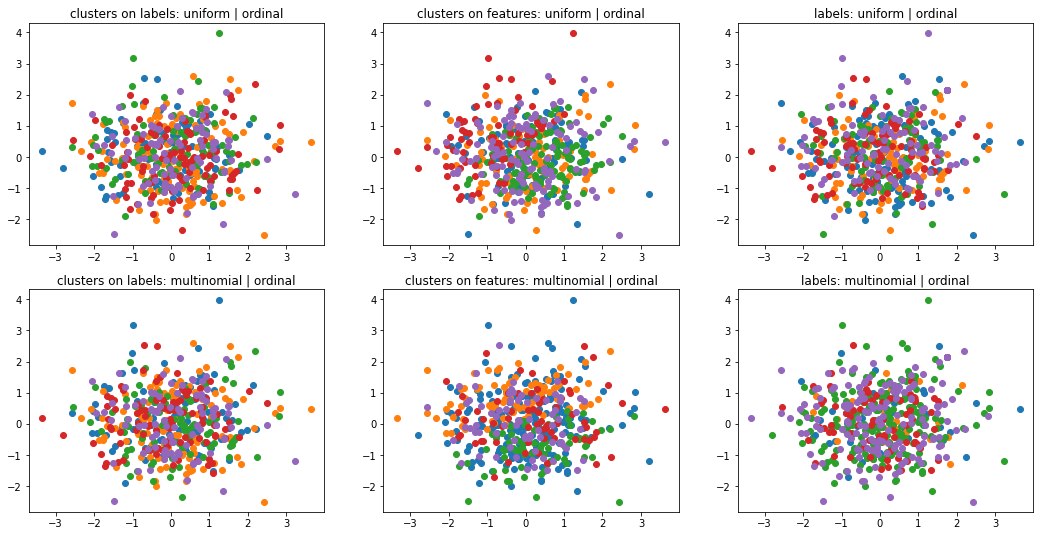

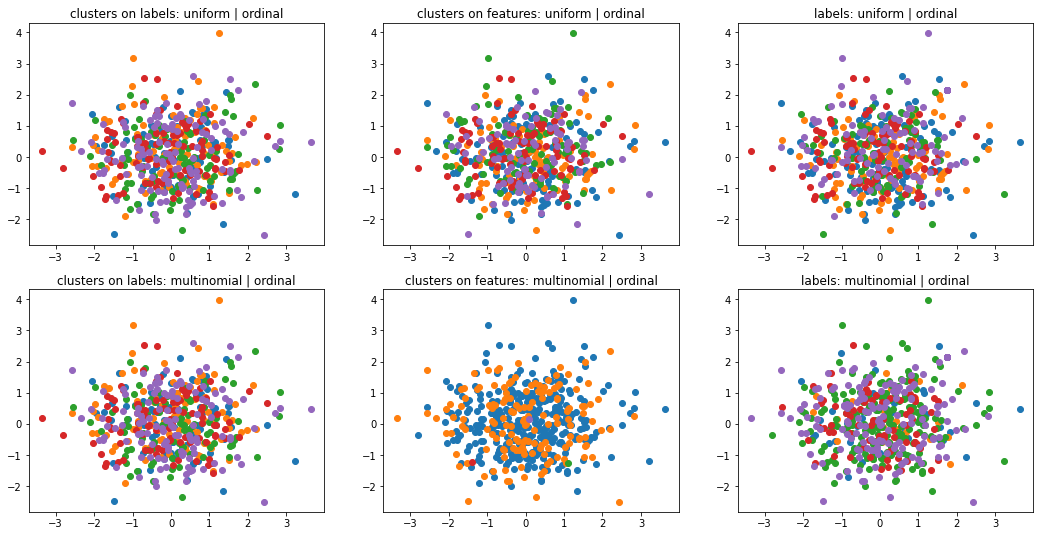

In [11]:
random_state = 42
features = np.random.normal(size=(n_samples, 2))
run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kmeans)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_gaussian_mixture)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=True, algorithm=run_kmodes)

<ipython-input-5-d452ad958182>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-d452ad958182>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-d452ad958182>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-d452ad958182>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


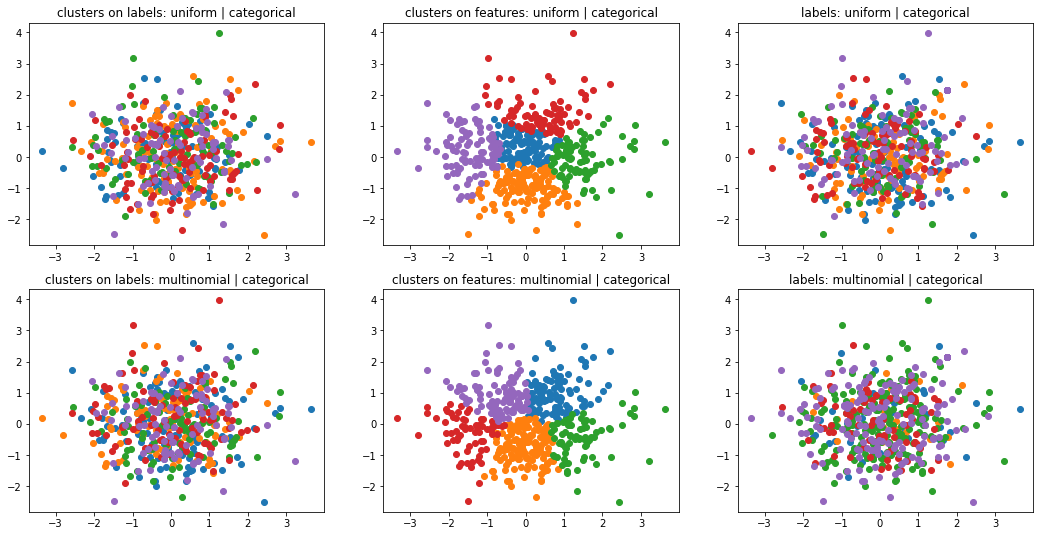

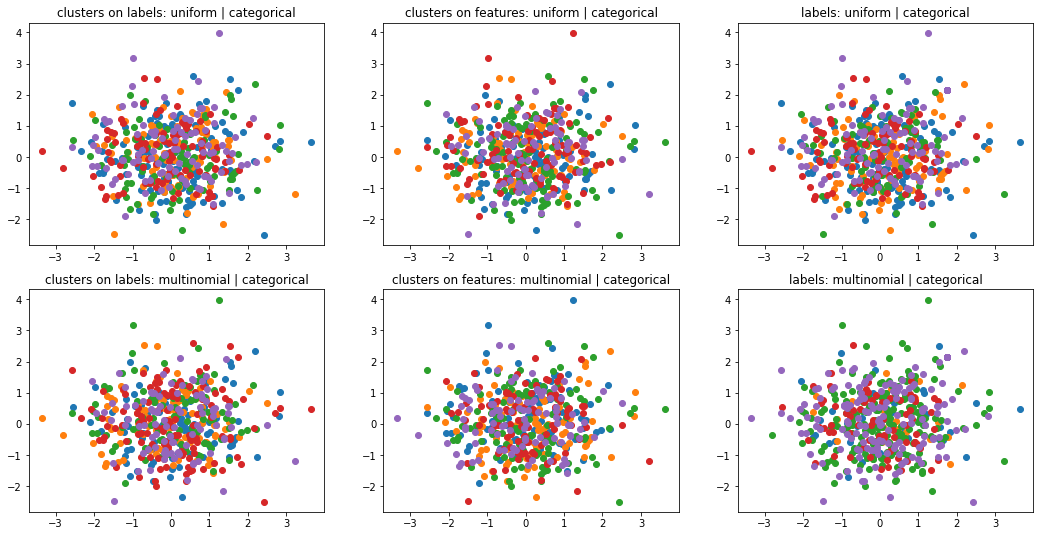

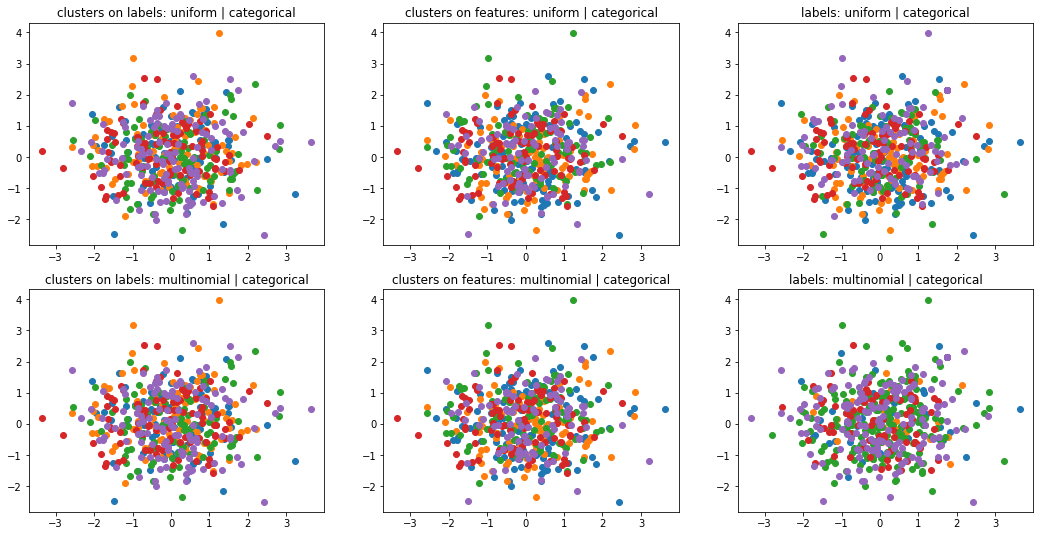

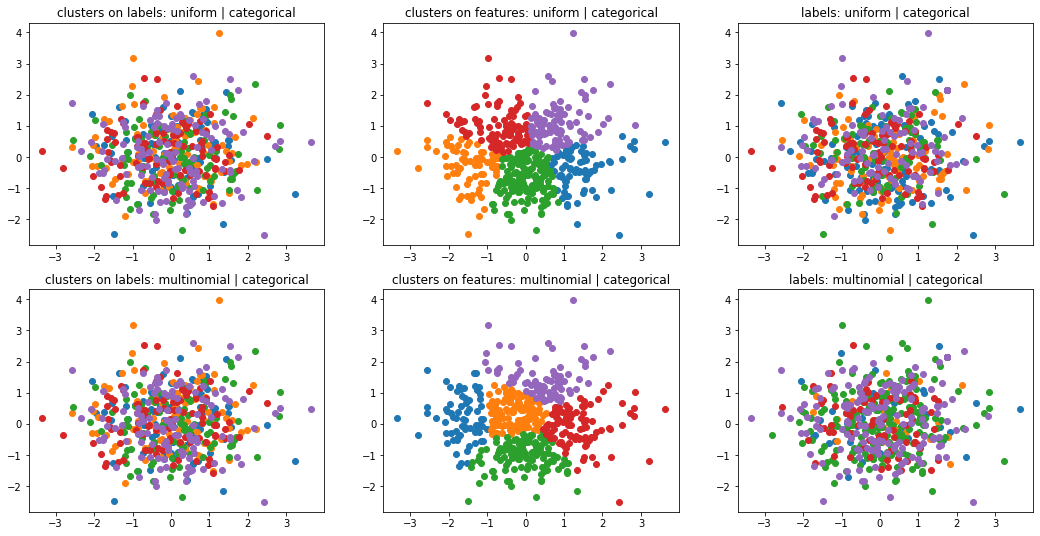

In [12]:
run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_kmeans)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_gaussian_mixture)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_kmodes)
run_ordinal_categorical_comparison(features, categorical_to_ordinal=False, algorithm=run_kprototypes)

<ipython-input-17-1fc06e946b55>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


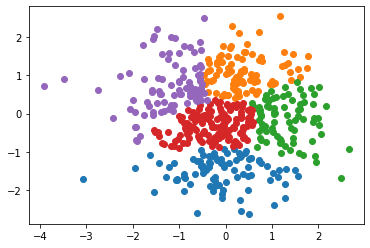

In [17]:
fig, axs = plt.subplots()
run_gaussian_mixture(n_clusters, features, features, axs, title='')
fig.show()

<ipython-input-4-f21834bdacce>:82: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


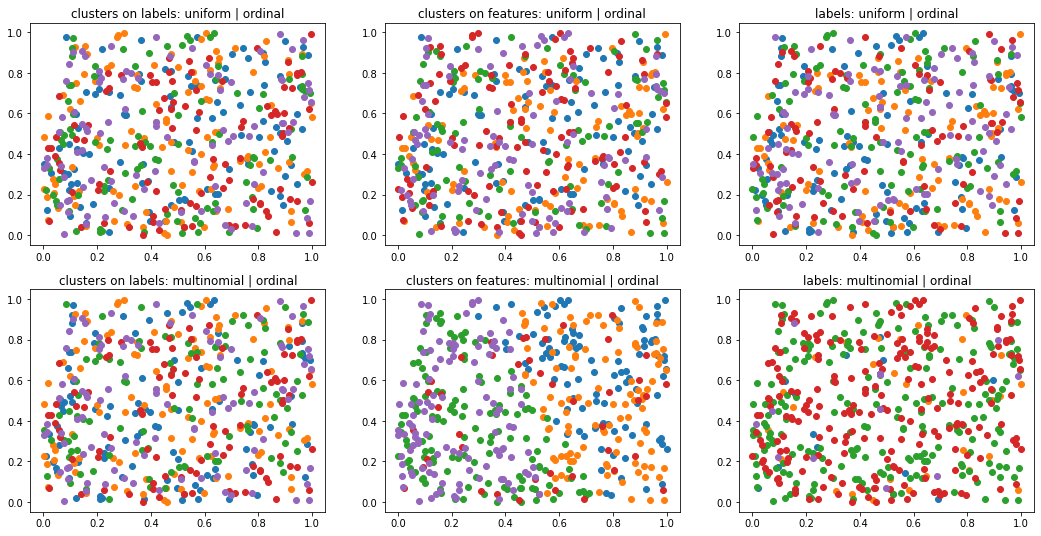

In [18]:
features = np.random.uniform(0.0, 1.0, size=(n_samples, 2))
run_ordinal_categorical_comparison(features)